# Neuronale Netze für Zähldaten 

Wiederholen Sie die Poisson-Regression für den Fisch-Datensatz, jetzt mit Keras. Aus der vorherigen Übung:

-----

Der folgende Datensatz enthält die Anzahl der Fische, die eine Gruppe von Campern in einem staatlichen Park gefangen hat (entnommen aus https://stats.idre.ucla.edu/r/dae/zip/). Ihre Aufgabe ist es, die Anzahl der Fische $y$ vorherzusagen, die von einer Gruppe von Anglern gefangen wurden. Wir haben einen kleinen Datensatz von 250 Gruppen, die einen Staatspark besucht und folgende Informationen geliefert haben: 

* Wie viele Personen in der Gruppe sind
* Die Anzahl der Kinder in der Gruppe
* Die Verwendung von Lebendködern
* Ob die Gruppe mit einem Camper in den Park kam. 

Teilen Sie den Datensatz in einen Trainingssatz und einen Testsatz auf. Verwenden Sie die ersten 200 Einträge zum Trainieren, die restlichen 50 zum Testen. Siehe unten für den Code zum Lesen der Daten.

## Setup

### Einbinden von Paketen

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp

np.__version__, tf.__version__, tfp.__version__

('1.23.4', '2.11.0', '0.19.0')

### Einlesen der Daten

In [65]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
import os
from urllib.request import urlretrieve
if not os.path.isfile('data/fishing.npz'):
    print("Downloading...")
    urlretrieve('http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz', filename = 'data/fishing.npz')
data = np.load('data/fishing.npz')
dateDownloaded = !date #Calling Linux
dateDownloaded

['Sat Jan 21 19:46:24 UTC 2023']

In [66]:
X_train = data['Xt'] #"livebait","camper","persons","child"
X_test = data['Xte']
y_train = data['yt']
y_test = data['yte']
pd.DataFrame(X_train[0:2])

,0,1,2,3
0,1.0,0.0,4.0,0.0
1,1.0,1.0,2.0,0.0


## Results from the Machine Learning excercise, we had. 

### LinearRegression

In [67]:
from sklearn.linear_model import LinearRegression
Xd = np.hstack([np.ones((X_train.shape[0],1)), X_train])
pd.DataFrame(Xd[0:2])
Xdt = np.hstack([np.ones((X_test.shape[0],1)), X_test])
X_train.shape,Xd.shape
model_skl = LinearRegression(fit_intercept=False)
res = model_skl.fit(Xd, y_train)
res.coef_

array([-8.49222821,  2.4822138 ,  2.95430727,  4.64953914, -5.47160051])

#### RMSE und NLL
Bestimmen Sie den mittleren quadratischen Fehler (Root Mean Square Error, RMSE) und die durchschnittliche negative Log-Likelihood (NLL) für den Testsatz. Für die NLL wird angenommen, dass die bedingte Wahrscheinlichkeitsverteilung (CPD) $p(y|x)$ durch die Dichte eines Gauß mit konstanter Varianz $\sigma^2$ gegeben ist. Schätzen Sie $\sigma^2$ anhand der Varianz der Residuen. Verwenden Sie die Varianzschätzung mit $1/N$. 


In [68]:
ypred = model_skl.predict(Xdt)
#ypred = np.ones_like(y_test) * np.median(y_train)
sigma_hat_2 = np.mean((y_test - ypred.flatten())**2)
np.sqrt(sigma_hat_2),sigma_hat_2,Xdt.shape

(8.588126386734231, 73.75591483452077, (50, 5))

In [69]:
0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_test - ypred.flatten())**2)/sigma_hat_2

3.5693191297796893

#### Vergleich mit Testsatz

Für den Testsatz: Stellen Sie den Mittelwert der vorhergesagten Anzahl der gefangenen Fische gegen die beobachtete Anzahl der gefangenen Fische. Fügen Sie außerdem das 2,5- und 97,25-Präzentil von p(y|x), der bedingten Vorhersageverteilung (CPD) von $y$ für ein gegebenes $x$, ein. Warum ist ein Gauß nicht ideal für diese Art von Daten? Für den Gauß sind das 2,5% und das 97,5% Perzentil näherungsweise gegeben durch $\mu \pm 1,96*\sigma$

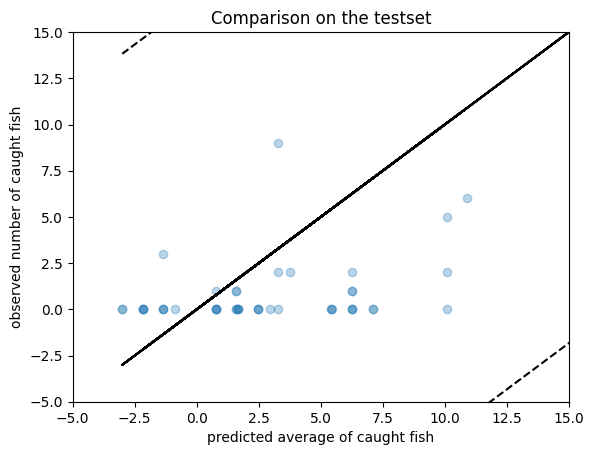

In [70]:
plt.scatter(ypred, y_test,alpha=0.3)
sort_idx=np.argsort(ypred,axis=0)
plt.plot(ypred[sort_idx].flatten(), ypred[sort_idx].flatten()+1.96*np.sqrt(sigma_hat_2),linestyle='dashed',c="black")
plt.plot(ypred[sort_idx].flatten(), ypred[sort_idx].flatten()-1.96*np.sqrt(sigma_hat_2),linestyle='dashed',c="black")
plt.plot(ypred, ypred, c="black")
plt.title('Comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.xlim(-5,15)
plt.ylim(-5,15)
plt.show()

### Poisson

Bei diesen Daten handelt es sich um Zähldaten. Zähldaten haben nur positive Werte und auch die Verteilung ist diskret. Man kann nicht 0,5 Fische fangen, und dass die CPD eine Wahrscheinlichkeit für eine negative Anzahl von Fischen hat, ist auch nicht ganz richtig. Eine Gauß-Verteilung als CPD ist daher nicht ideal. Verwenden Sie nun eine Poisson-Verteilung als CPD. Wenn wir eine Poisson-Verteilung annehmen, dann ist die Wahrscheinlichkeit, $k$ Fische zu fangen, gegeben durch 
$$
  p(k) = \exp(-\mu) \frac{\mu^k}{k!}
$$

und die NLL somit durch:

$$
 log(p(k)) = -\mu + k \cdot \log(\mu) - log(k!)
$$

wobei $\mu$ der Erwartungswert ist. In unserem Fall ist das die durchschnittliche Anzahl der erwarteten Fische.

Bei der probabilistischen Interpretation der linearen Regression ist $y_i$ für ein gegebenes $x_i$ wie ein Gauß verteilt. Der Parameter $\mu_i$ aus $N(\mu_i,\sigma^2)$ ist aus $x_i$ über $\mu_i= \beta^T \cdot x_i$ bestimmt worden. Da $\mu_i$ in der Poissonschen bekannt ist, muss es positiv sein. Wir leiten daher $\beta^T \cdot x_i$ zunächst durch ein Exponential, um es positiv zu machen, und können so $\mu_i=exp(\beta^T \cdot x_i)$ bestimmen.

Verwenden Sie einen Gradientenabstiegsansatz, um die Lösung für die Parameter zu finden. Berechnen Sie den RMSE und die NLL für die Testmenge.

Hinweis: Auf dem Trainingsset sollte die NLL für die Parameterwerte (1,1,1,1,1) ca. 1508 betragen und der Gradient 

In [71]:
def NLL(y_train, Xd, w):
    mu = np.exp(np.matmul(Xd,w))
    ret = np.zeros_like(mu)
    for i in range(ret.shape[0]):
        ret[i] = mu[i] - y_train[i]*np.log(mu[i]) + np.log(1.0*np.math.factorial(int(y_train[i])))
    return np.mean(ret)
w = np.ones(5)
NLL(y_train, Xd,w)

1507.9856602262082

In [72]:
def gradNLL(y_train, Xd, w):
    mu = np.exp(np.matmul(Xd,w))
    #print(mu.shape)
    ret = np.zeros_like(Xd)
    for i in range(Xd.shape[0]):
        mux = Xd[i] * mu[i]
        ret[i] = -mux + y_train[i] *Xd[i]
    return np.mean(ret, axis=0)

NLL(y_train, Xd,np.ones(5))
np.round(gradNLL(y_train, Xd,np.ones(5)),2)
#1518.61, 1403.99, 1171.02, 5701.91, 3258.7

array([-1518.61, -1403.99, -1171.02, -5701.91, -3258.7 ])

In [73]:
from tqdm import tqdm 
w = np.ones(5)
hist = []
for i in tqdm(range(10000)):
    if (i % 10 == 0):
        hist.append(NLL(y_train, Xd,w))
    w = w + 0.001 * gradNLL(y_train, Xd,w)
w, NLL(y_train, Xd,w)

100%|██████████| 10000/10000 [00:05<00:00, 1740.76it/s]


(array([-1.74007527,  0.56500613,  0.66091814,  0.93220074, -1.62023821]),
 3.3806067025761606)

(0.0, 5.0)

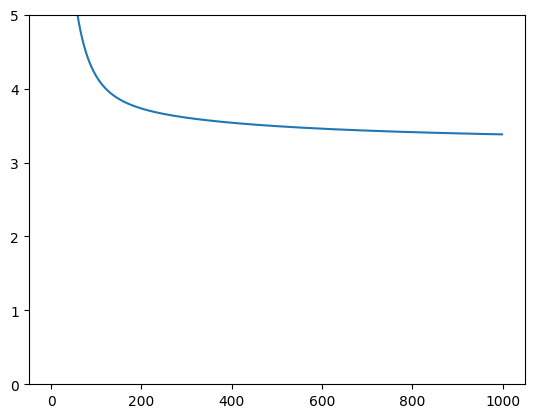

In [74]:
plt.plot(hist)
plt.ylim(0,5)

In [75]:
mupred = np.exp(np.matmul(Xdt, w))
np.sqrt(np.mean((mupred - y_test)**2)), NLL(y_test, Xdt,w)
RMSE_sk =np.sqrt(np.mean((mupred - y_test)**2))
NLL_sk = NLL(y_test, Xdt,w)
print(RMSE_sk)
print(NLL_sk)

df2 = pd.DataFrame(
         { 'RMSE' : RMSE_sk, 'MAE' : None, 'NLL' : NLL_sk}, index=['Poisson Regression (Grad_decent)']
)

7.389176645536159
2.8768358338221574


## A) Poisson-Regression unter Verwendung eines mit Keras erstellten NN

Wiederholen Sie die Analyse von oben mit Keras. Sie können (müssen aber nicht) tfp verwenden.

In [76]:
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors

np.random.seed(42)
tf.random.set_seed(42)

In [77]:
from keras import Sequential, Model
from keras.layers import Dense, Input 
from keras.optimizers import Adam

inputs = Input(shape=(X_train.shape[1],))  
rate = Dense(1, activation=tf.exp)(inputs) # Definition of a single layer with one output
p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate) # We use exponential of the output to model the rate 

# Glueing the NN and the output layer together. Note that output p_y is a tf.distribution
model_p = Model(inputs=inputs, outputs=p_y) 

# The second argument is the output of the model and thus a tfp-distribution. It's as simple as calling log_prob to calculate the log-probability of the observation that is needed to calculate the NLL.
def NLL(y_true, y_hat): 
  return -y_hat.log_prob(y_true)

model_p.compile(Adam(learning_rate=0.01), loss=NLL)
model_p.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
 distribution_lambda_2 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [78]:
hist_p = model_p.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=2000, verbose=0)

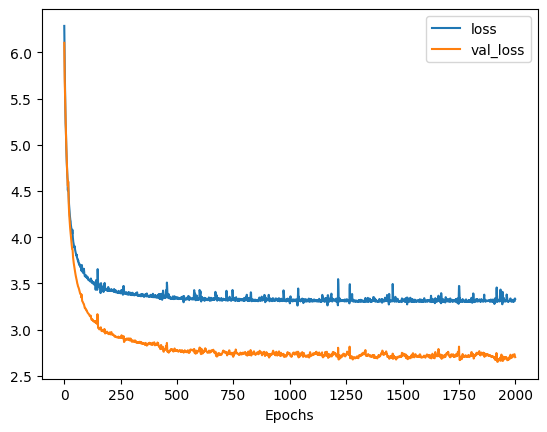

In [79]:
plt.plot(hist_p.history['loss'])
plt.plot(hist_p.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.show()

In [80]:
model = Model(inputs=inputs, outputs=p_y) 
y_hat_test = model.predict(X_test).flatten()


rmse=np.sqrt(np.mean((y_test - y_hat_test)**2))
mae=np.mean(np.abs(y_test - y_hat_test)) 

NLL = model_p.evaluate(X_test, y_test) #returns the NLL 

df3 = pd.DataFrame(
         { 'RMSE' : rmse, 'MAE' : mae, 'NLL' : NLL}, index=['Poisson Regression (TFP)']
)
pd.concat([df2,df3])

2/2 [==============================] - 0s 2ms/step - loss: 2.7010


,RMSE,MAE,NLL
Poisson Regression (Grad_decent),7.389177,NaN,2.876836
Poisson Regression (TFP),6.243396,2.86,2.700972


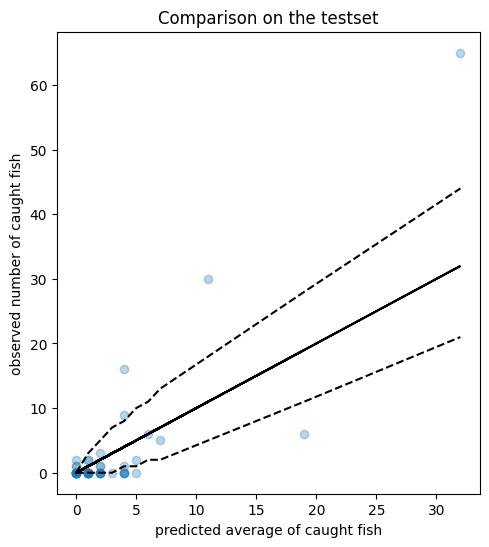

In [81]:
from scipy.stats import poisson
lower=poisson.ppf(0.025, y_hat_test)
upper=poisson.ppf(0.975, y_hat_test)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.title('Comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), lower[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), upper[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test, y_hat_test, c="black")